In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Flatten, Dense, Input, concatenate, Dropout
from tensorflow.keras.layers import Conv2D, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.utils import to_categorical #원 핫 인코딩

from tensorflow.keras.applications import Xception, ResNet50, InceptionV3, MobileNet
from tensorflow.keras.callbacks import EarlyStopping

import shutil
import os
import cv2

from datetime import datetime

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
dataset_path = '/content/gdrive/MyDrive/Colab Notebooks/data'
shutil.copy(os.path.join(dataset_path, 'food_yespizza.zip'), '/content')

'/content/food_yespizza.zip'

- food
  - train
    - burger
    - chicken
    - pasta
    - pizza
    - porkcutlet
    - sushi
    - tteokbokki
  - test
    - ..

In [4]:
# 꼭대기 폴더 'food' 안에 각 폴더+정답이름이미지폴더 만들어서 진행할 것

DATA_ROOT_DIR = os.path.join('/content', 'food') #꼭대기 폴더 지정
TRAIN_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, 'train')
TEST_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, 'test')

In [5]:
### food.zip 압축풀기
import zipfile
with zipfile.ZipFile(os.path.join('/content', 'food_yespizza.zip'), 'r') as target_file:
    target_file.extractall(TRAIN_DATA_ROOT_DIR)

In [6]:
# test폴더 - Pasta,Burger, ... 폴더 생성
os.mkdir(TEST_DATA_ROOT_DIR)
os.mkdir(os.path.join(TEST_DATA_ROOT_DIR, 'pasta'))
os.mkdir(os.path.join(TEST_DATA_ROOT_DIR, 'burger'))
os.mkdir(os.path.join(TEST_DATA_ROOT_DIR, 'chicken'))
os.mkdir(os.path.join(TEST_DATA_ROOT_DIR, 'sushi'))
os.mkdir(os.path.join(TEST_DATA_ROOT_DIR, 'pizza'))
os.mkdir(os.path.join(TEST_DATA_ROOT_DIR, 'porkcutlet'))
os.mkdir(os.path.join(TEST_DATA_ROOT_DIR, 'tteokbokki'))

In [7]:
import glob
ratio = 0.2

src_root_dir = "/content/food/train/"
dst_root_dir = "/content/food/test/"

label_name_list = os.listdir(TRAIN_DATA_ROOT_DIR)
for label_name in label_name_list:
    train_image_file_list = glob.glob(src_root_dir + label_name + "/*.*")
    print("==========================================================")
    
    print("total [%s] image file nums => [%s]"%(label_name, len(train_image_file_list)))
    
    split_num = int(ratio * len(train_image_file_list))
    print("분리할 갯수 : ", split_num)
    
    test_image_file_list = train_image_file_list[0:split_num]
    
    # move
    move_nums = 0
    for image_file in test_image_file_list:
        shutil.move(image_file, dst_root_dir + label_name)
        move_nums = move_nums + 1
        
    print("total move nums => ", move_nums)
    print("===========================================================")

total [sushi] image file nums => [2321]
분리할 갯수 :  464
total move nums =>  464
total [pasta] image file nums => [2909]
분리할 갯수 :  581
total move nums =>  581
total [porkcutlet] image file nums => [4092]
분리할 갯수 :  818
total move nums =>  818
total [chicken] image file nums => [3580]
분리할 갯수 :  716
total move nums =>  716
total [burger] image file nums => [4024]
분리할 갯수 :  804
total move nums =>  804
total [pizza] image file nums => [2959]
분리할 갯수 :  591
total move nums =>  591
total [tteokbokki] image file nums => [2330]
분리할 갯수 :  466
total move nums =>  466


In [8]:
label_name_list

['sushi', 'pasta', 'porkcutlet', 'chicken', 'burger', 'pizza', 'tteokbokki']

## 훈련용 데이터

In [9]:
import cv2

train_data_list = []
train_label_list = [] #정답

class_dict = {'burger':0, 'chicken':1, 'pasta':2, 'pizza':3, 'porkcutlet':4, 'sushi':5, 'tteokbokki':6}

start_time = datetime.now()
for label_name in label_name_list:
  file_path = os.path.join(TRAIN_DATA_ROOT_DIR, label_name)
  img_file_list = glob.glob(file_path + '/*.*') #여기서 읽어온 것 아니고 읽어올 리스트만 가져온 것

  for img in img_file_list:
    src_img = cv2.imread(img, cv2.IMREAD_COLOR)
    src_img = cv2.resize(src_img, dsize=(128, 128)) #사진크기
    src_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)

    train_data_list.append(src_img)
    train_label_list.append(class_dict[label_name]) #정답(문자-> 0, 1로 바꿔주기; dict[key값]으로 0, 1 가져오기. 간단하게 이렇게 할수도)
end_time = datetime.now()
print('Elapsed Time : ', end_time-start_time)

Elapsed Time :  0:00:39.263325


In [10]:
X_train = np.array(train_data_list).astype('float32')
y_train = np.array(train_label_list).astype('float32')

print(X_train.shape, y_train.shape)

(17775, 128, 128, 3) (17775,)


## 테스트용 데이터

In [12]:
test_data_list = []
test_label_list = [] #정답

for label_name in label_name_list:
  file_path = os.path.join(TEST_DATA_ROOT_DIR, label_name)
  img_file_list = glob.glob(file_path + '/*.*') #여기서 읽어온 것 아니고 읽어올 리스트만 가져온 것

  for img in img_file_list:
    src_img = cv2.imread(img, cv2.IMREAD_COLOR)
    src_img = cv2.resize(src_img, dsize=(128, 128)) 
    src_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)

    test_data_list.append(src_img)
    test_label_list.append(class_dict[label_name])

In [13]:
X_test = np.array(test_data_list).astype('float32')
y_test = np.array(test_label_list).astype('float32')

print(X_test.shape, y_test.shape)

(4440, 128, 128, 3) (4440,)


In [14]:
len(os.listdir(TRAIN_DATA_ROOT_DIR))

7

In [15]:
# 정규화
X_train = X_train / 255.0
X_test = X_test / 255.0

## 전이학습

In [16]:
# 모바일넷
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128

base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))
base_model.summary()

17225924/17225924 [==============================] - 1s 0us/step
Model: "mobilenet_1.00_128"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 64, 64, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 64, 64, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 64, 64, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 64, 64, 32) 

In [17]:
class_nums = len(os.listdir(TRAIN_DATA_ROOT_DIR)) #정답 개수
print(class_nums)

7


In [18]:
model = Sequential()

model.add(base_model)
model.add(GlobalAveragePooling2D())


model.add(Dense(64, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(0.25))

model.add(Dense(128, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(0.25))

model.add(Dense(256, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(0.25))

model.add(Dense(class_nums, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_128 (Functio  (None, 4, 4, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 64)                65600     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0

In [19]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.00001), metrics=['accuracy'])

In [20]:
from datetime import datetime
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


# earlystopping = EarlyStopping(monitor='val_loss',  # 모니터 기준 설정 (val loss) 
#                               patience=5,          # 5회 Epoch동안 개선되지 않는다면 종료
#                              )


start_time = datetime.now()

hist = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=128) #callbacks=[earlystopping]

end_time = datetime.now()
print('elapsed time = ', end_time-start_time)

Epoch 1/50
139/139 [==============================] - 37s 172ms/step - loss: 2.6983 - accuracy: 0.2195 - val_loss: 1.4839 - val_accuracy: 0.4403
Epoch 2/50
139/139 [==============================] - 22s 158ms/step - loss: 1.9206 - accuracy: 0.3433 - val_loss: 1.1313 - val_accuracy: 0.6455
Epoch 3/50
139/139 [==============================] - 22s 158ms/step - loss: 1.4984 - accuracy: 0.4601 - val_loss: 0.8900 - val_accuracy: 0.7489
Epoch 4/50
139/139 [==============================] - 22s 157ms/step - loss: 1.2869 - accuracy: 0.5376 - val_loss: 0.6987 - val_accuracy: 0.8077
Epoch 5/50
139/139 [==============================] - 22s 157ms/step - loss: 1.0712 - accuracy: 0.6183 - val_loss: 0.5714 - val_accuracy: 0.8369
Epoch 6/50
139/139 [==============================] - 22s 158ms/step - loss: 0.9239 - accuracy: 0.6763 - val_loss: 0.4833 - val_accuracy: 0.8604
Epoch 7/50
139/139 [==============================] - 22s 158ms/step - loss: 0.8027 - accuracy: 0.7257 - val_loss: 0.4228 - val_ac

In [ ]:
# 0.9829 / 0.9500 : epochs=50, batch_size=128, learning_rate=0.00001

In [39]:
model.save('yespizza.h5')

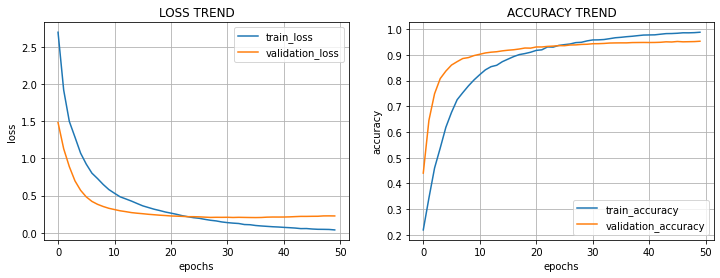

In [21]:
plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
plt.title("LOSS TREND")
plt.xlabel("epochs")
plt.ylabel('loss')
plt.grid()

plt.plot(hist.history['loss'], label='train_loss')
plt.plot(hist.history['val_loss'], label='validation_loss')
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.title("ACCURACY TREND")
plt.xlabel("epochs")
plt.ylabel('accuracy')
plt.grid()

plt.plot(hist.history['accuracy'], label='train_accuracy')
plt.plot(hist.history['val_accuracy'], label='validation_accuracy')
plt.legend(loc='best')

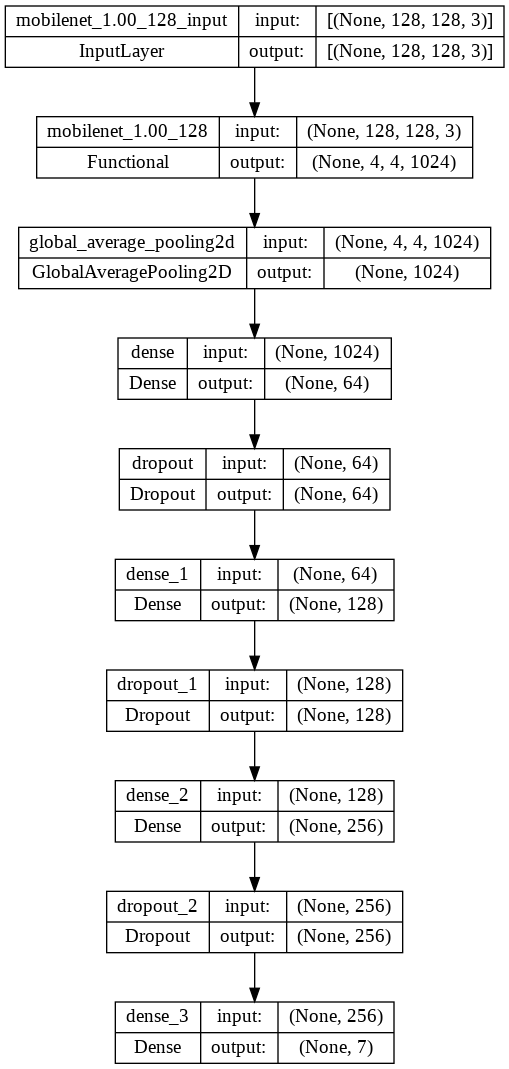

In [62]:
from tensorflow.keras.utils import plot_model

# 모델 시각화
#plot_model(model, to_file='model.png')
plot_model(model, to_file='model_shapes.png', show_shapes=True)

## predict

- 반복문으로 만들어보기

In [22]:
# 이미지 불러오기
src_img1 = cv2.imread("./pred/test1.jpg", cv2.IMREAD_COLOR)
src_img2 = cv2.imread("./pred/test2.jpg", cv2.IMREAD_COLOR)
src_img3 = cv2.imread("./pred/test3.jpg", cv2.IMREAD_COLOR)
src_img4 = cv2.imread("./pred/test4.jpg", cv2.IMREAD_COLOR)
src_img5 = cv2.imread("./pred/test5.jpg", cv2.IMREAD_COLOR)
src_img6 = cv2.imread("./pred/test6.jpg", cv2.IMREAD_COLOR)
src_img7 = cv2.imread("./pred/test7.jpg", cv2.IMREAD_COLOR)
src_img8 = cv2.imread("./pred/test8.jpg", cv2.IMREAD_COLOR)
src_img9 = cv2.imread("./pred/test9.jpg", cv2.IMREAD_COLOR)

#넘파이 배열로 불러옴
print(type(src_img1), src_img1.shape)
print(type(src_img2), src_img2.shape)
print(type(src_img3), src_img3.shape)
print(type(src_img4), src_img4.shape)
print(type(src_img5), src_img5.shape)
print(type(src_img6), src_img6.shape)
print(type(src_img7), src_img7.shape)
print(type(src_img8), src_img8.shape)
print(type(src_img9), src_img9.shape)


# RGB로 색상순서변환
dst_img1 = cv2.cvtColor(src_img1, cv2.COLOR_BGR2RGB)
dst_img2 = cv2.cvtColor(src_img2, cv2.COLOR_BGR2RGB)
dst_img3 = cv2.cvtColor(src_img3, cv2.COLOR_BGR2RGB)
dst_img4 = cv2.cvtColor(src_img4, cv2.COLOR_BGR2RGB)
dst_img5 = cv2.cvtColor(src_img5, cv2.COLOR_BGR2RGB)
dst_img6 = cv2.cvtColor(src_img6, cv2.COLOR_BGR2RGB)
dst_img7 = cv2.cvtColor(src_img7, cv2.COLOR_BGR2RGB)
dst_img8 = cv2.cvtColor(src_img8, cv2.COLOR_BGR2RGB)
dst_img9 = cv2.cvtColor(src_img9, cv2.COLOR_BGR2RGB)

# 테스트하기 위해서 이미지 가공
dst_img1 = cv2.resize(dst_img1, dsize=(128, 128))
dst_img2 = cv2.resize(dst_img2, dsize=(128, 128))
dst_img3 = cv2.resize(dst_img3, dsize=(128, 128))
dst_img4 = cv2.resize(dst_img4, dsize=(128, 128))
dst_img5 = cv2.resize(dst_img5, dsize=(128, 128))
dst_img6 = cv2.resize(dst_img6, dsize=(128, 128))
dst_img7 = cv2.resize(dst_img7, dsize=(128, 128))
dst_img8 = cv2.resize(dst_img8, dsize=(128, 128))
dst_img9 = cv2.resize(dst_img9, dsize=(128, 128))

<class 'numpy.ndarray'> (3024, 3024, 3)
<class 'numpy.ndarray'> (3024, 3024, 3)
<class 'numpy.ndarray'> (2270, 2270, 3)
<class 'numpy.ndarray'> (2800, 2800, 3)
<class 'numpy.ndarray'> (2798, 2798, 3)
<class 'numpy.ndarray'> (1163, 1170, 3)
<class 'numpy.ndarray'> (1298, 1170, 3)
<class 'numpy.ndarray'> (2661, 2661, 3)
<class 'numpy.ndarray'> (1143, 1170, 3)


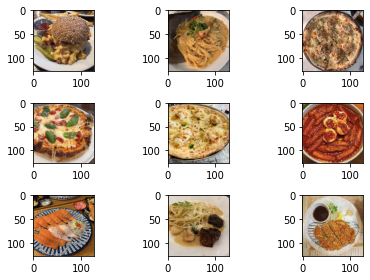

In [23]:
plt.subplot(3, 3, 1)
  
plt.imshow(dst_img1)

plt.subplot(3, 3, 2)
plt.imshow(dst_img2)

plt.subplot(3, 3, 3)
plt.imshow(dst_img3)

plt.subplot(3, 3, 4)
plt.imshow(dst_img4)

plt.subplot(3, 3, 5)
plt.imshow(dst_img5)

plt.subplot(3, 3, 6)
plt.imshow(dst_img6)

plt.subplot(3, 3, 7)
plt.imshow(dst_img7)

plt.subplot(3, 3, 8)
plt.imshow(dst_img8)

plt.subplot(3, 3, 9)
plt.imshow(dst_img9)
plt.tight_layout()

In [24]:
# 정규화
dst_img1 = dst_img1 / 255.0
dst_img2 = dst_img2 / 255.0
dst_img3 = dst_img3 / 255.0
dst_img4 = dst_img4 / 255.0
dst_img5 = dst_img5 / 255.0
dst_img6 = dst_img6 / 255.0
dst_img7 = dst_img7 / 255.0
dst_img8 = dst_img8 / 255.0
dst_img9 = dst_img9 / 255.0

In [25]:
# predict위해 차원 맞추기(4차원 필요)
test_image_list = []

test_image_list.append(dst_img1)
test_image_list.append(dst_img2)
test_image_list.append(dst_img3)
test_image_list.append(dst_img4)
test_image_list.append(dst_img5)
test_image_list.append(dst_img6)
test_image_list.append(dst_img7)
test_image_list.append(dst_img8)
test_image_list.append(dst_img9)


test_image_array = np.array(test_image_list) #3차원 한번더 묶어서 4차원으로 차원 맞추기
test_image_array.shape

(9, 128, 128, 3)

In [27]:
pred = model.predict(test_image_array)

1/1 [==============================] - 1s 537ms/step


In [28]:
print(pred.shape)
print(pred)

(9, 7)
[[9.99797642e-01 7.06272040e-05 2.45201882e-05 3.02693843e-05
  8.74739635e-06 2.15310629e-05 4.66086021e-05]
 [3.19843490e-13 9.56844937e-10 1.00000000e+00 6.29629071e-10
  3.58509028e-10 4.32126557e-12 2.46045087e-08]
 [8.32110672e-05 7.79226830e-04 9.88500059e-01 5.24042174e-03
  3.97178903e-03 7.42324701e-05 1.35110377e-03]
 [9.86270970e-06 5.46512418e-08 5.41016698e-06 9.99977112e-01
  5.82771281e-06 1.43129751e-06 3.13433276e-07]
 [1.66365533e-06 1.08224995e-05 1.63412705e-01 8.36547434e-01
  4.42211149e-06 2.33958804e-06 2.06360546e-05]
 [1.64403265e-11 1.12544674e-09 2.83423958e-07 4.82006612e-08
  2.02413375e-09 1.22059651e-09 9.99999642e-01]
 [4.26289652e-08 2.37438269e-09 1.67846395e-08 1.15974323e-08
  3.88117414e-08 9.99999762e-01 1.52991603e-07]
 [5.10606196e-06 4.56523667e-05 9.99695182e-01 8.57935229e-05
  2.03730269e-05 3.94876406e-06 1.43938785e-04]
 [2.18328310e-07 2.69036235e-07 7.48894209e-08 7.35658830e-07
  9.99996305e-01 2.20329525e-06 2.10319413e-07]]


In [29]:
{'burger':0, 'chicken':1, 'pasta':2, 'pizza':3, 'porkcutlet':4, 'sushi':5, 'tteokbokki':6}
class_name = ['burger', 'chicken', 'pasta', 'pizza', 'porkcutlet', 'sushi', 'tteokbokki']
for i in range(len(pred)):
    class_index = np.argmax(pred[i])
    print(class_name[class_index], pred[i].max())

burger 0.99979764
pasta 1.0
pasta 0.98850006
pizza 0.9999771
pizza 0.83654743
tteokbokki 0.99999964
sushi 0.99999976
pasta 0.9996952
porkcutlet 0.9999963


In [30]:
# 상위 3개 예측값
top3 = 3
for i in range(len(pred)):
    sorted_index = pred[i].argsort()
    sorted_index = sorted_index[::-1]
    print("===================================")
    print(sorted_index)
    for j in range(top3):
        pred_val = pred[i, sorted_index[j]]
        class_index = sorted_index[j]
        print("예측값 : ", class_name[class_index], pred_val)

[0 1 6 3 2 5 4]
예측값 :  burger 0.99979764
예측값 :  chicken 7.0627204e-05
예측값 :  tteokbokki 4.6608602e-05
[2 6 1 3 4 5 0]
예측값 :  pasta 1.0
예측값 :  tteokbokki 2.4604509e-08
예측값 :  chicken 9.568449e-10
[2 3 4 6 1 0 5]
예측값 :  pasta 0.98850006
예측값 :  pizza 0.0052404217
예측값 :  porkcutlet 0.003971789
[3 0 4 2 5 6 1]
예측값 :  pizza 0.9999771
예측값 :  burger 9.86271e-06
예측값 :  porkcutlet 5.827713e-06
[3 2 6 1 4 5 0]
예측값 :  pizza 0.83654743
예측값 :  pasta 0.1634127
예측값 :  tteokbokki 2.0636055e-05
[6 2 3 4 5 1 0]
예측값 :  tteokbokki 0.99999964
예측값 :  pasta 2.8342396e-07
예측값 :  pizza 4.820066e-08
[5 6 0 4 2 3 1]
예측값 :  sushi 0.99999976
예측값 :  tteokbokki 1.529916e-07
예측값 :  burger 4.2628965e-08
[2 6 3 1 4 0 5]
예측값 :  pasta 0.9996952
예측값 :  tteokbokki 0.00014393879
예측값 :  pizza 8.579352e-05
[4 5 3 1 0 6 2]
예측값 :  porkcutlet 0.9999963
예측값 :  sushi 2.2032953e-06
예측값 :  pizza 7.3565883e-07


In [32]:
print(test_image_file_list)

['/content/food/train/tteokbokki/1846.jpg', '/content/food/train/tteokbokki/1372.jpg', '/content/food/train/tteokbokki/1417.jpg', '/content/food/train/tteokbokki/522.jpg', '/content/food/train/tteokbokki/1211.jpg', '/content/food/train/tteokbokki/1567.jpg', '/content/food/train/tteokbokki/1949.jpg', '/content/food/train/tteokbokki/796.jpg', '/content/food/train/tteokbokki/1756.jpg', '/content/food/train/tteokbokki/573.jpg', '/content/food/train/tteokbokki/602.jpg', '/content/food/train/tteokbokki/339.jpg', '/content/food/train/tteokbokki/2067.jpg', '/content/food/train/tteokbokki/1274.jpg', '/content/food/train/tteokbokki/1334.jpg', '/content/food/train/tteokbokki/2345.jpg', '/content/food/train/tteokbokki/1203.jpg', '/content/food/train/tteokbokki/1611.jpg', '/content/food/train/tteokbokki/2021.jpg', '/content/food/train/tteokbokki/1348.jpg', '/content/food/train/tteokbokki/1368.jpg', '/content/food/train/tteokbokki/2422.jpg', '/content/food/train/tteokbokki/1974.jpg', '/content/food/

In [33]:
class_name

['burger', 'chicken', 'pasta', 'pizza', 'porkcutlet', 'sushi', 'tteokbokki']

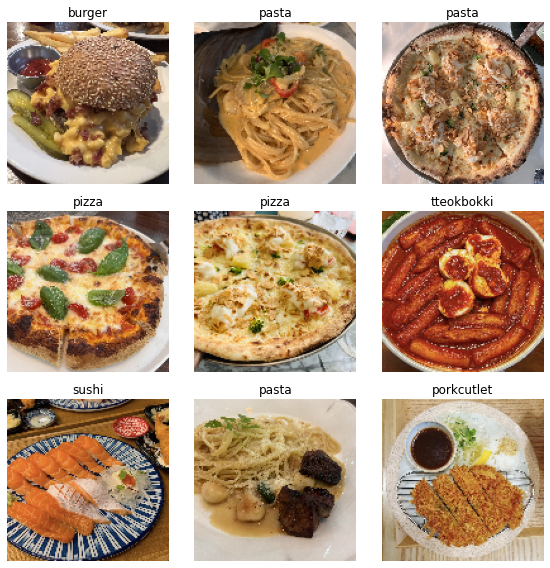

In [38]:
plt.figure(figsize=(8,8))

for i in range(len(pred)):
  plt.subplot(3, 3, i+1)
  class_index = np.argmax(pred[i])
  plt.title(class_name[class_index])
  plt.imshow(test_image_list[i])
  plt.axis('off')
plt.tight_layout()